<a href="https://colab.research.google.com/github/IT21161056/Papaya-Buddy/blob/anoj/Hybrid_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the EfficientNet model for healthy/unhealthy classification
efficientnet_model = torch.load('/content/drive/MyDrive/models/efficientnet_model_full.pth', map_location=device)
efficientnet_model.to(device)
efficientnet_model.eval()

# Load the Vision Transformer model for disease classification
vit_model = torch.load('/content/drive/MyDrive/models/vit_entire_model.pth', map_location=device)
vit_model.to(device)
vit_model.eval()

<ipython-input-3-3ab464d19487>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_model = torch.load('/content/drive/MyDrive/models/efficientnet_model_full.pth', 

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Define the preprocessing transform used during training
transform_health = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to model's input size
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Use the same mean and std as EfficientNet
])

transform_disease = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to model's input size
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Use the same mean and std as ViT
])

In [ ]:
def hybrid_inference(image_path,device):
    disease_labels = {
      0: 'Cercospora',
      1: 'Mosaic',
    }
    image= Image.open(image_path).convert('RGB')

    eff_input = transform_health(image).unsqueeze(0).to(device)
    with torch.no_grad():
        eff_output = efficientnet_model(eff_input)


    _, eff_pred = torch.max(eff_output, 1)

    if eff_pred.item() == 1:
        vit_input = transform_disease(image).unsqueeze(0).to(device)
        with torch.no_grad():
            vit_output = vit_model(vit_input).logits

        # Apply softmax to get confidence
        vit_confidence = F.softmax(vit_output, dim=1)
        confidence, vit_pred = torch.max(vit_confidence, 1)

        disease_class = vit_pred.item()
        disease_name = disease_labels.get(disease_class, 'Unknown')

        return f"Unhealthy, Disease: {disease_name}, Confidence: {confidence.item()*100:.2f}%"

    else:
        return "Healthy"

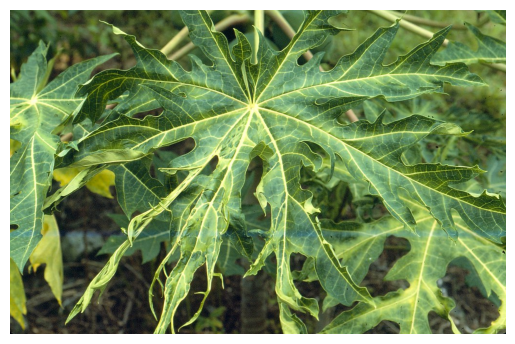

In [ ]:
# Input image path
image_path = '/content/drive/MyDrive/test data/mosaic/9777372061_970d26fdce_b.jpg'

# Display the image
image1 = Image.open(image_path).convert('RGB')
plt.imshow(image1)
plt.axis('off')
plt.show()

In [ ]:
# Example usage
result = hybrid_inference(image_path,device)
print(result)

Unhealthy, Disease: Mosaic, Confidence: 85.26%


# Confusion Matrix

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Custom Dataset class to read images from 'test_data' folder
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform

        # Given class names
        self.class_names = ['cercospora', 'mosaic','healthy']

        # Create a label encoder with predefined class names
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.class_names)

        # Get all images and their labels
        self.image_paths = []
        self.labels = []
        for cls in self.class_names:
            cls_folder = os.path.join(folder_path, cls)
            for fname in os.listdir(cls_folder):
                if fname.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(cls_folder, fname))
                    self.labels.append(cls)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
        label = self.labels[idx]

        # Encode the label using the label encoder
        label = self.label_encoder.transform([label])[0]

        if self.transform:
            image = self.transform(image)

        return image, label  # Return image and its corresponding integer label

In [ ]:
# Define image size
IMG_SIZE = 224

# Define the transformation for testing (no augmentation for testing)
test_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.33), interpolation=transforms.InterpolationMode.BICUBIC),  # Crop the best area
    transforms.RandomHorizontalFlip(p=0.5),  # Flip with 50% probability
    transforms.RandomRotation(degrees=5, expand=False),  # Restrict rotation to ±5°
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.02),  # Minor color adjustments
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

In [ ]:
# Path to your test data folder
test_folder_path = '/content/drive/MyDrive/hybrid_model_test_data'

# Create the Dataset and DataLoader
test_dataset = CustomDataset(folder_path=test_folder_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

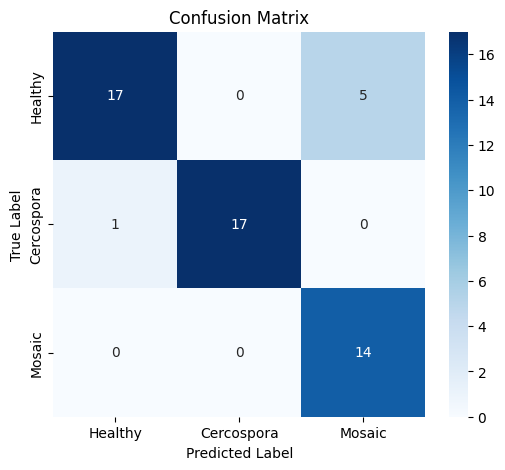

In [ ]:
import os
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to your test data
test_data_path = '/content/drive/MyDrive/hybrid_model_test_data'

# Function to predict the health status and disease type
def hybrid_inference(image_path, device):
    # Open and preprocess the image
    image= Image.open(image_path).convert('RGB')

    # Step 1: Use EfficientNet to classify health status (Healthy/Unhealthy)
    eff_input = transform_health(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        eff_output = efficientnet_model(eff_input)

    # Assuming EfficientNet output is a 2-class (Healthy, Unhealthy) classification
    _, eff_pred = torch.max(eff_output, 1)

    # Step 2: If Unhealthy, use Vision Transformer to classify disease
    if eff_pred.item() == 1:  # If the prediction is "Unhealthy" (index 1)
        vit_input = transform_disease(image).unsqueeze(0).to(device)
        with torch.no_grad():
            vit_output = vit_model(vit_input).logits

        # Apply softmax to get confidence
        vit_confidence = F.softmax(vit_output, dim=1)
        confidence, vit_pred = torch.max(vit_confidence, 1)

        return vit_pred.item()

    else:
        return 2

# Initialize lists to store true and predicted labels
true_labels = []
pred_labels = []

# Loop through the test dataset and generate predictions
for folder in ['healthy', 'cercospora', 'mosaic']:
    folder_path = os.path.join(test_data_path, folder)

    # Assign the correct label based on folder
    if folder == 'healthy':
        true_label = 2  # Healthy label (no disease)
    elif folder == 'cercospora':
        true_label = 0  # Cercospora
    elif folder == 'mosaic':
        true_label = 1  # Mosaic

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Predict using the hybrid model
        pred_label = hybrid_inference(image_path, device)

        # Append the true and predicted labels
        true_labels.append(true_label)
        pred_labels.append(pred_label)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Cercospora', 'Mosaic'], yticklabels=['Healthy', 'Cercospora', 'Mosaic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Hybrid model

In [ ]:
import torch
import torch.nn as nn

class HybridModel(nn.Module):
    def __init__(self, efficientnet_model, vit_model):
        super(HybridModel, self).__init__()
        self.efficientnet = efficientnet_model
        self.vit = vit_model

    def forward(self, x):
        eff_output = self.efficientnet(x)
        _, eff_pred = torch.max(eff_output, 1)

        if eff_pred.item() == 1:
            vit_output = self.vit(x).logits
            _, vit_pred = torch.max(vit_output, 1)
            return eff_pred.item(), vit_pred.item()
        else:
            return eff_pred.item(), None  # Healthy, so no disease classification


In [ ]:
# Instantiate the hybrid model with both models
hybrid_model = HybridModel(efficientnet_model, vit_model)

# Save the entire model (including architecture and weights)
torch.save(hybrid_model, '/content/drive/MyDrive/models/hybrid_model.pth')



# Load the Hybrid model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the entire model
HYBRID_MODEL = torch.load('/content/drive/MyDrive/models/hybrid_model.pth')

# Move the model to the correct device (CPU or GPU)
HYBRID_MODEL.to(device)

# Set the model to evaluation mode (if you are doing inference)
HYBRID_MODEL.eval()


<ipython-input-6-fa5d69c2cea8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  HYBRID_MODEL = torch.load('/content/drive/MyDrive/models/hybrid_model.pth')


HybridModel(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sc

In [ ]:
# Input image path
# image_path = '/content/drive/MyDrive/test data/mosaic/9777372061_970d26fdce_b.jpg'
image_path ='/content/drive/MyDrive/test data/cercospora/IMG_20240724_132325.jpg'


test_image = Image.open(image_path).convert('RGB')

input_image = transform_health(test_image).unsqueeze(0).to(device)

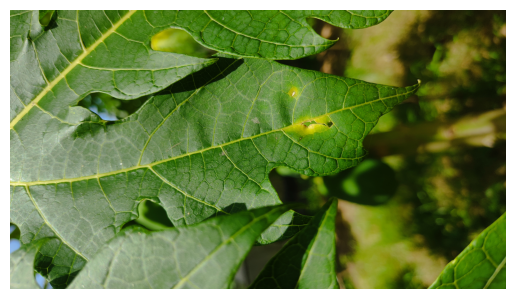

Unhealthy Leaf, Disease: Cercospora


In [ ]:
from PIL import Image
# Run inference
with torch.no_grad():
    health_status, disease_pred = HYBRID_MODEL(input_image)


disease_labels = {
    0: 'Cercospora',
    1: 'Mosaic',
    # Add more disease names here according to your model's training
}

# Display the image

plt.imshow(test_image)
plt.axis('off')  # Hide axes
plt.show()

# Interpret the results
if health_status == 0:
    print("Healthy Leaf")
else:
    # For unhealthy, get the disease name
    disease_name = disease_labels[disease_pred] if disease_pred is not None else "No disease"
    print(f"Unhealthy Leaf, Disease: {disease_name}")
